In [19]:
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
import matplotlib.pyplot as plt


In [20]:
# Load dataset
hf = h5py.File("../epfl3.h5", "r")

In [21]:
# 1715 entries
# each entry : 112x112x32
# 32 slices
nb_entries = len(hf.keys()) 
list_keys = list(hf.keys())

# Split train-validation set
# 80% train - 20% validation
ratio = 0.8
keys_random = np.random.permutation(list_keys)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]

In [22]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [23]:
# Load training set
slices_train_3d = np.zeros((len(keys_train),112,112,32))
for i, key in enumerate(keys_train):
    # Get the "frame" of the entry "key"
    # Normalize : dividing by 255 (RGB)
    slices_train_3d[i] = hf.get(key)["frame"][0]/255

# Load the validation set 
slices_test_3d = np.zeros((len(keys_test),112,112,32))
for i, key in enumerate(keys_test):
    slices_test_3d[i] = hf.get(key)["frame"][0]/255

In [31]:
def plot_history(hist, loss_name='loss', save_name = 'title'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(save_name)
    title = 'Hist' + save_name + ".pdf"
    plt.savefig(title)
    plt.show()
    

Epoch 1/5
5/5 [==============================] - 18s 4s/step - loss: 8.3807e-05 - vxm_dense_transformer_loss: 8.3807e-05 - vxm_dense_flow_loss: 1.4015e-06
Epoch 2/5
5/5 [==============================] - 18s 4s/step - loss: 2.8259e-04 - vxm_dense_transformer_loss: 2.8259e-04 - vxm_dense_flow_loss: 1.0021e-05
Epoch 3/5
5/5 [==============================] - 17s 3s/step - loss: 2.1635e-04 - vxm_dense_transformer_loss: 2.1634e-04 - vxm_dense_flow_loss: 6.2061e-05
Epoch 4/5
5/5 [==============================] - 16s 3s/step - loss: 3.7540e-04 - vxm_dense_transformer_loss: 3.7538e-04 - vxm_dense_flow_loss: 2.1650e-04
Epoch 5/5
5/5 [==============================] - 17s 3s/step - loss: 3.9062e-04 - vxm_dense_transformer_loss: 3.9055e-04 - vxm_dense_flow_loss: 7.3253e-04


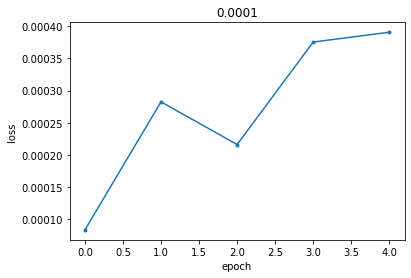

Epoch 1/5
5/5 [==============================] - 17s 3s/step - loss: 2.6153e-04 - vxm_dense_transformer_loss: 2.5957e-04 - vxm_dense_flow_loss: 9.0913e-04
Epoch 2/5
5/5 [==============================] - 20s 4s/step - loss: 1.9693e-04 - vxm_dense_transformer_loss: 1.9623e-04 - vxm_dense_flow_loss: 3.2647e-04
Epoch 3/5
5/5 [==============================] - 18s 4s/step - loss: 3.8989e-04 - vxm_dense_transformer_loss: 3.8962e-04 - vxm_dense_flow_loss: 1.2365e-04
Epoch 4/5
5/5 [==============================] - 17s 3s/step - loss: 3.8053e-04 - vxm_dense_transformer_loss: 3.8027e-04 - vxm_dense_flow_loss: 1.2323e-04
Epoch 5/5
5/5 [==============================] - 17s 3s/step - loss: 1.4242e-04 - vxm_dense_transformer_loss: 1.4202e-04 - vxm_dense_flow_loss: 1.8453e-04


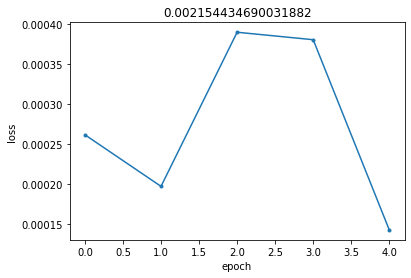

Epoch 1/5
5/5 [==============================] - 17s 3s/step - loss: 1.3402e-04 - vxm_dense_transformer_loss: 1.2802e-04 - vxm_dense_flow_loss: 1.2913e-04
Epoch 2/5
5/5 [==============================] - 18s 4s/step - loss: 3.2915e-04 - vxm_dense_transformer_loss: 3.2740e-04 - vxm_dense_flow_loss: 3.7728e-05
Epoch 3/5
5/5 [==============================] - 17s 3s/step - loss: 2.7111e-04 - vxm_dense_transformer_loss: 2.6953e-04 - vxm_dense_flow_loss: 3.4019e-05
Epoch 4/5
5/5 [==============================] - 17s 3s/step - loss: 2.9264e-04 - vxm_dense_transformer_loss: 2.9044e-04 - vxm_dense_flow_loss: 4.7271e-05
Epoch 5/5
5/5 [==============================] - 17s 3s/step - loss: 7.0074e-05 - vxm_dense_transformer_loss: 6.7295e-05 - vxm_dense_flow_loss: 5.9859e-05


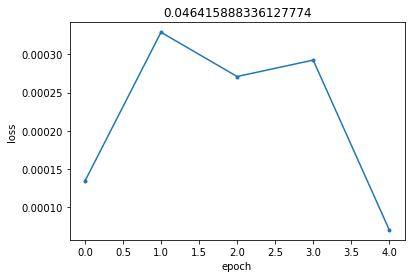

Epoch 1/5
5/5 [==============================] - 17s 3s/step - loss: 3.7435e-04 - vxm_dense_transformer_loss: 3.4922e-04 - vxm_dense_flow_loss: 2.5130e-05
Epoch 2/5
5/5 [==============================] - 17s 3s/step - loss: 4.1857e-04 - vxm_dense_transformer_loss: 4.1402e-04 - vxm_dense_flow_loss: 4.5493e-06
Epoch 3/5
5/5 [==============================] - 17s 3s/step - loss: 3.2855e-04 - vxm_dense_transformer_loss: 3.2617e-04 - vxm_dense_flow_loss: 2.3812e-06
Epoch 4/5
5/5 [==============================] - 17s 3s/step - loss: 2.1590e-04 - vxm_dense_transformer_loss: 2.1351e-04 - vxm_dense_flow_loss: 2.3965e-06
Epoch 5/5
5/5 [==============================] - 18s 4s/step - loss: 3.0789e-04 - vxm_dense_transformer_loss: 3.0551e-04 - vxm_dense_flow_loss: 2.3781e-06


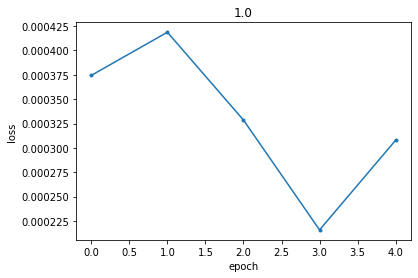

In [33]:
# UNET architecture

vol_shape = (112, 112, 32) # 32 slices
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-4,0,4)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = vxm_data_generator(slices_train_3d, batch_size = 1)
    hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=1);
    # Visualize the losses
    plot_history(hist, save_name = str(lambda_))
    title = "weights" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

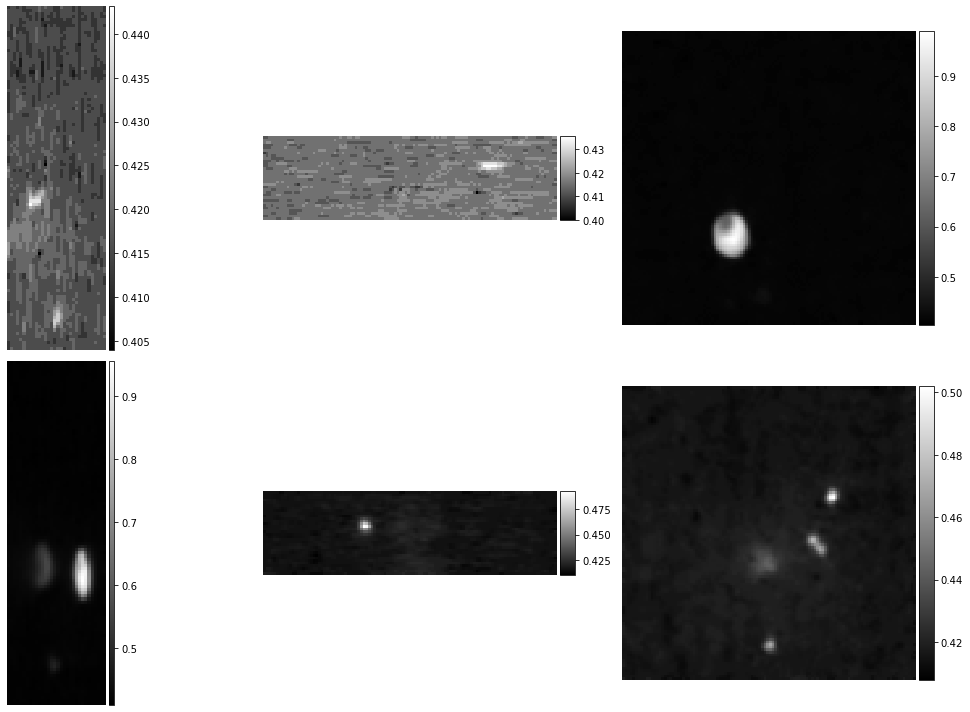

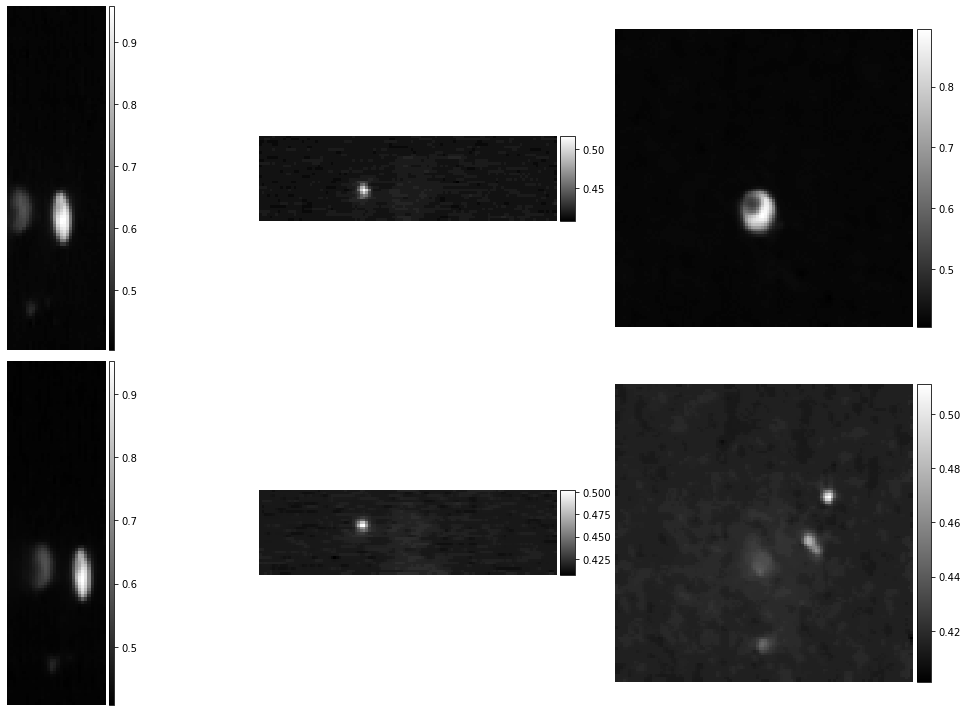

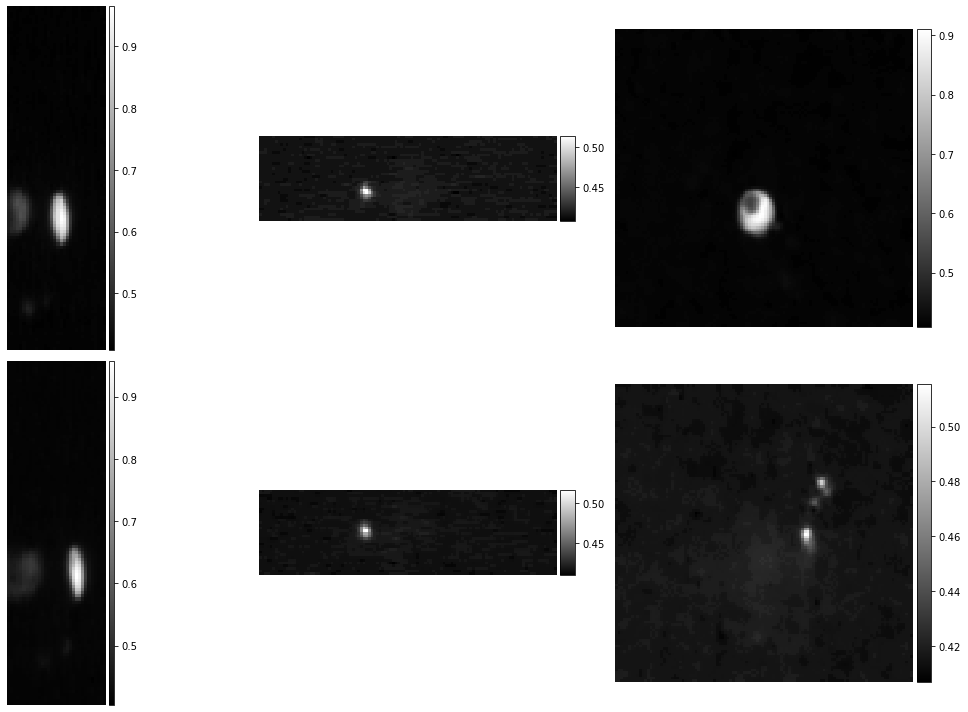

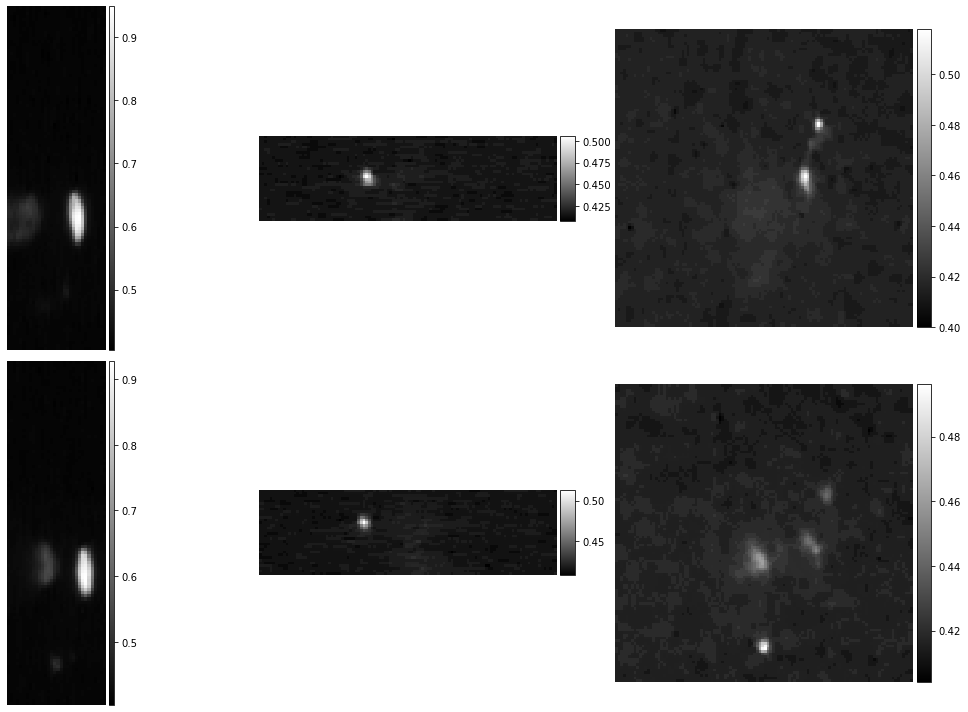

In [34]:
for lambda_ in lambdas:
    title = "weights" + str(lambda_) + ".keras"
    vxm_model.load_weights(title)
    # Validation set generator
    val_generator = vxm_data_generator(slices_test_3d, batch_size = 1)
    val_input, _ = next(val_generator)
    our_val_pred = vxm_model.predict(val_input);
    
    # Fixed image : Reference
    mid_slices_fixed = [np.take(np.squeeze(val_input[1]), vol_shape[d]//2, axis=d) for d in range(3)]
    mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
    mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

    # Prediction image : output
    moved_pred = our_val_pred[0].squeeze()
    mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
    mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
    mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

    # Plot sagital, coronal & transverse planes
    ne.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);